In [ ]:
import numpy as np
import torch
from torch import nn, optim, save
from torch.nn import functional as F
from torchvision import datasets
from torchvision.utils import make_grid
from torch.nn import Module, Sequential, Linear, ReLU, Sigmoid, Dropout, Tanh
from torch import Tensor, randn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

from torch import ones, zeros
from torch.autograd import Variable

from torch.nn import BCELoss
from google.colab import drive

from collections import defaultdict, deque
import datetime
import pickle
import time

import torch
import torch.distributed as dist

import errno
import os

In [ ]:
import os
import numpy as np
import torch
from PIL import Image
import json

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip -P "2019Deepfashion2**" "/content/drive/MyDrive/master/an2/sri/data/validation.zip" -d "/content/"

In [ ]:
base_path = r"/content/validation/"
annos_path = base_path + r"/annos"
images_path = base_path + r"/image"

In [ ]:
class ClothesDetectionDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.annos = list(sorted(os.listdir(os.path.join(root, "annos"))))
        self.imgs = list(sorted(os.listdir(os.path.join(root, "image"))))

    def __getitem__(self, idx):
        # load images ad masks

        img_path = os.path.join(self.root, "image", self.imgs[idx])
        annos_path = os.path.join(self.root, "annos", self.annos[idx])

        img = Image.open(img_path).convert("RGB")

        num_objs = 0
        boxes = []
        labels = []

        with open(annos_path) as json_file:
            data = json.load(json_file)

            for item in data.keys():
                if item.startswith("item"):
                    num_objs += 1

                    boxes.append(data[item]["bounding_box"])
                    labels.append(data[item]["category_id"]%13)

        # print(self.annos[idx], self.imgs[idx], boxes, labels, idx, img.size)
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
           img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
# import torchvision
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# num_classes = 13
# in_features = model.roi_heads.box_predictor.cls_score.in_features

# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=13,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 12046 (delta 2), reused 0 (delta 0), pack-reused 12034
Receiving objects: 100% (12046/12046), 13.43 MiB | 2.04 MiB/s, done.
Resolving deltas: 100% (8394/8394), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = ClothesDetectionDataset(base_path, get_transform(train=True))
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=utils.collate_fn)
# For Training
print("here")
images,targets = next(iter(data_loader))

images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
print(len(images), len(targets))
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  

NameError: ignored

In [ ]:
import math
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# CUDA_LAUNCH_BLOCKING=1

# def get_instance_segmentation_model(num_classes):
#     # load an instance segmentation model pre-trained on COCO
#     model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

#     # get the number of input features for the classifier
#     in_features = model.roi_heads.box_predictor.cls_score.in_features
#     # replace the pre-trained head with a new one
#     model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#     # now get the number of input features for the mask classifier
#     in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
#     hidden_layer = 256
#     # and replace the mask predictor with a new one
#     model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
#                                                        hidden_layer,
#                                                        num_classes)

#     return model

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device", device)

# our dataset has two classes only - background and person
num_classes = 13
# use our dataset and defined transformations
dataset = ClothesDetectionDataset(base_path, get_transform(train=True))
dataset_test = ClothesDetectionDataset(base_path, get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=1,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=1,
    collate_fn=utils.collate_fn)

# get the model using our helper function
# model = get_instance_segmentation_model(num_classes)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    # evaluate(model, data_loader_test, device=device)

print("That's it!")

device cuda


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


Datele de ieșire de afișat au fost trunchiate la ultimele 5000 linii.
Epoch: [6]  [14330/16052]  eta: 0:05:59  lr: 0.000050  loss: 0.1082 (0.1297)  loss_classifier: 0.0519 (0.0630)  loss_box_reg: 0.0488 (0.0559)  loss_objectness: 0.0008 (0.0020)  loss_rpn_box_reg: 0.0056 (0.0089)  time: 0.2021  data: 0.0061  max mem: 4410
Epoch: [6]  [14340/16052]  eta: 0:05:57  lr: 0.000050  loss: 0.1206 (0.1297)  loss_classifier: 0.0528 (0.0630)  loss_box_reg: 0.0444 (0.0559)  loss_objectness: 0.0006 (0.0020)  loss_rpn_box_reg: 0.0027 (0.0089)  time: 0.2064  data: 0.0061  max mem: 4410
Epoch: [6]  [14350/16052]  eta: 0:05:55  lr: 0.000050  loss: 0.1254 (0.1297)  loss_classifier: 0.0615 (0.0630)  loss_box_reg: 0.0430 (0.0559)  loss_objectness: 0.0006 (0.0020)  loss_rpn_box_reg: 0.0052 (0.0089)  time: 0.2082  data: 0.0058  max mem: 4410
Epoch: [6]  [14360/16052]  eta: 0:05:53  lr: 0.000050  loss: 0.0906 (0.1297)  loss_classifier: 0.0360 (0.0630)  loss_box_reg: 0.0409 (0.0559)  loss_objectness: 0.0005 (

In [ ]:
PATH = "state_dict_model_1.pt"

torch.save(model.state_dict(), r"/content/drive/MyDrive/master/an2/sri/data/"+PATH)

In [ ]:
import math
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
num_classes = 13

PATH = r"/content/drive/MyDrive/master/an2/sri/data/"+r"state_dict_model_1.pt"
_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = _model.roi_heads.box_predictor.cls_score.in_features
_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
image_id = 20

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device", device)
dataset_test = ClothesDetectionDataset(base_path, get_transform(train=False))

_model.to(device)

img, _ = dataset_test[image_id]
_model.eval()
with torch.no_grad():
    prediction = _model([img.to(device)])

device cuda


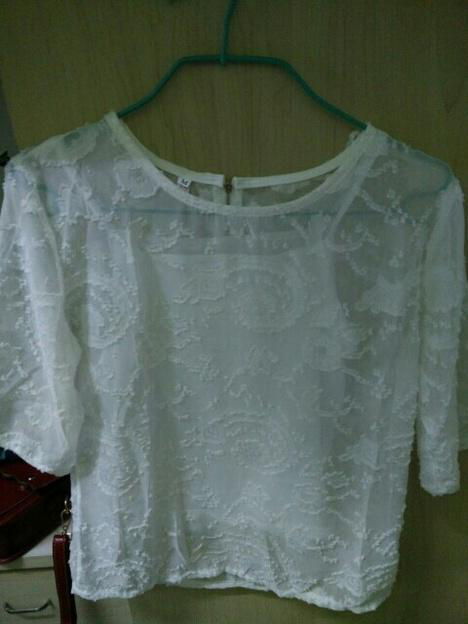

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [ ]:
categories = {
    1: "short sleeve top",
    2: "long sleeve top",
    3: "short sleeve outwear",
    4: "long sleeve outwear",
    5: "vest",
    6: "sling",
    7: "shorts",
    8: "trousers",
    9: "skirt",
    10: "short sleeve dress",
    11: "long sleeve dress",
    12: "vest dress",
    0: "sling dress"              
}
categories[1]
prediction

[{'boxes': tensor([[  5.8292, 112.5474, 453.1176, 611.8074],
          [  1.7949, 106.8528, 468.0000, 612.2563],
          [  2.5595, 104.4508, 468.0000, 621.0090],
          [  4.2620, 107.0045, 468.0000, 620.1775]], device='cuda:0'),
  'labels': tensor([ 2,  1, 10, 11], device='cuda:0'),
  'scores': tensor([0.7188, 0.4555, 0.0597, 0.0560], device='cuda:0')}]

In [ ]:
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
# Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())
img, _ = dataset_test[image_id]
# Image.fromarray(prediction[0]['boxes'][0, 0].mul(255).byte().cpu().numpy())
boxes = prediction[0]['boxes'].cpu().numpy()
labels = prediction[0]['labels'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()

_img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
draw = ImageDraw.Draw(_img)
idx = 0
# fnt = ImageFont.truetype("arial.ttf", 15)
for box in boxes:
    
    if scores[idx] > 0.5:
        draw.rectangle(((box[0], box[1]), (box[2], box[3])))
        draw.text((box[0], box[1]), categories[labels[idx]],  fill=(255,255,255,255))

    idx+=1

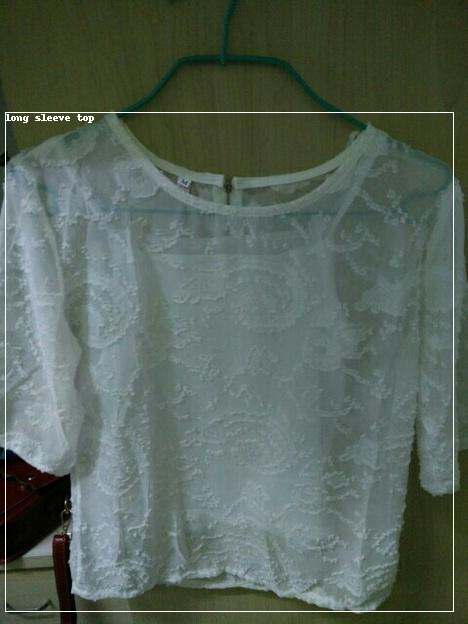

In [ ]:
_img